# Final project: Activity Recognition

The final assignment is to implement a classifier for activity recognition based on data from the phone’s sensors.

For this task, first the acceleration using the sensors of a phone was recorded. Then an HMM classifier that should be able to discriminate between, standing still, walking and running was implemented and its functionality verified.

In [1]:
from PattRecClasses import DiscreteD, GaussD, HMM, MarkovChain
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

### Data - Import and Pre-processing

(array([ 79., 230., 190., 220., 247., 240., 408., 449., 205.,  22.]),
 array([-0.00368195, -0.00023376,  0.00321442,  0.0066626 ,  0.01011078,
         0.01355896,  0.01700714,  0.02045532,  0.0239035 ,  0.02735168,
         0.03079987]),
 <BarContainer object of 10 artists>)

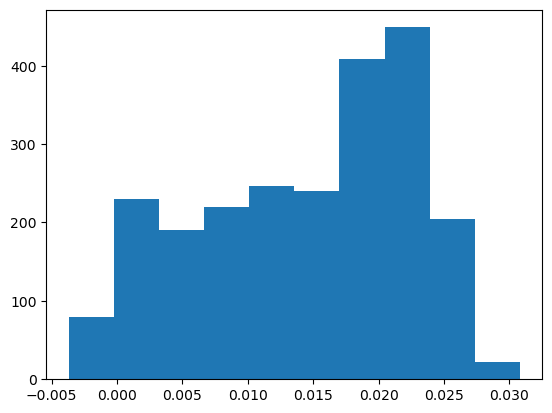

In [2]:
# import
s0 = pd.read_csv('Data/Standing.csv')
# drop unnecessary columns
s0 = s0.drop(columns = ['time', 'gFTotal'])
# moving average + drop NaN due to filtering
s0 = s0.rolling(window=10).mean().dropna()
# convert dataframe into array
s0 = s0.values

# now do that for all instances
s1 = pd.read_csv('Data/Standing2.csv')
s1 = s1.drop(columns = ['time', 'gFTotal'])
s1 = s1.rolling(window=10).mean().dropna().values
s2 = pd.read_csv('Data/Standing3.csv')
s2 = s2.drop(columns = ['time', 'gFTotal'])
s2 = s2.rolling(window=10).mean().dropna().values
s3 = pd.read_csv('Data/Standing4.csv')
s3 = s3.drop(columns = ['time', 'gFTotal'])
s3 = s3.rolling(window=10).mean().dropna().values

standing = np.concatenate([s0, s1, s2])
standing = np.concatenate([standing, s3])

standing_a = np.zeros(len(standing))
for i in range(len(standing)):
    standing_a[i] = standing[i][0]**2 + standing[i][1]**2 + standing[i][2]**2

w0 = pd.read_csv('Data/Walking.csv')
w0 = w0.drop(columns = ['time', 'gFTotal'])
w0 = w0.rolling(window=10).mean().dropna().values
w1 = pd.read_csv('Data/Walking2.csv')
w1 = w1.drop(columns = ['time', 'gFTotal'])
w1 = w1.rolling(window=10).mean().dropna().values
w2 = pd.read_csv('Data/Walking3.csv')
w2 = w2.drop(columns = ['time', 'gFTotal'])
w2 = w2.rolling(window=10).mean().dropna().values
w3 = pd.read_csv('Data/Walking4.csv')
w3 = w3.drop(columns = ['time', 'gFTotal'])
w3 = w3.rolling(window=10).mean().dropna().values

walking = np.concatenate([w0, w1, w2])
walking = np.concatenate([walking, w3])

r0 = pd.read_csv('Data/Running.csv')
r0 = r0.drop(columns = ['time', 'gFTotal'])
r0 = r0.rolling(window=10).mean().dropna().values
r1 = pd.read_csv('Data/Running2.csv')
r1 = r1.drop(columns = ['time', 'gFTotal'])
r1 = r1.rolling(window=10).mean().dropna().values
r2 = pd.read_csv('Data/Running3.csv')
r2 = r2.drop(columns = ['time', 'gFTotal'])
r2 = r2.rolling(window=10).mean().dropna().values
r3 = pd.read_csv('Data/Running4.csv')
r3 = r3.drop(columns = ['time', 'gFTotal'])
r3 = r3.rolling(window=10).mean().dropna().values

running = np.concatenate([r0, r1, r2])
running = np.concatenate([running, r3])

walking_a = np.zeros(len(walking))
for i in range(len(walking)):
    walking_a[i] = walking[i][0]**2+walking[i][1]**2+walking[i][2]**2
    
running_a = np.zeros(len(running))
for i in range(len(running)):
    running_a[i] = running[i][0]**2+running[i][1]**2+running[i][2]**2

plt.hist(standing[:,0])
#plt.hist(walking_a)
#plt.hist(running_a)

### Create and initialize HMM

In [3]:
# infinite HMM, with three states: standing (S1), walking (S2), running (S3)

q = np.array([1/3, 1/3, 1/3])
A  = np.array([[1/3, 1/3, 1/3], [1/3, 1/3, 1/3], [1/3, 1/3, 1/3]])
mc = MarkovChain(q, A) 

g1 = GaussD(means=[0, 0, 0], stdevs=1) # Distribution for state 'standing'
g2 = GaussD(means=[0, 0, 0], stdevs=1) # Distribution for state 'walking'
g3 = GaussD(means=[0, 0, 0], stdevs=1) # Distribution for state 'running'
h  = HMM(mc, [g1, g2, g3])           # The HMM


h.train(standing)


TypeError: 'int' object is not iterable

### Train HMM

In [ ]:
0.1339874267578125**2+0.5119781494140625**2+1.28692626953125**2

1.9362534792162478

### Verify HMM